# Errors and Data Filtering

All data fields contain corresponding errors, which should be used to correctly interpret the significance of the data.  Additionally, there are some filters based on data quality metrics in the data files that are recommended for most scientific applications.

In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt

In [2]:
filename = 'data/20200207.001_lp_5min-fitcal.h5'

## Error Fields
Electron density errors are found in the `FittedParams/dNe` array.  Errors for all other parameters can be found in the `FittedParams/Errors` array, which is constructed analogously to the [Fits](fits) array.

In [3]:
with h5py.File(filename, 'r') as h5:

    rng = h5['FittedParams/Range'][:]
    Ne = h5['FittedParams/Ne'][:]
    utime = h5['Time/UnixTime'][:,0]

    # Read in all error arrays
    dNe = h5['FittedParams/dNe'][:]
    dTi = h5['FittedParams/Errors'][:,:,:,0,1]
    dTe = h5['FittedParams/Errors'][:,:,:,-1,1]
    dVlos = h5['FittedParams/Errors'][:,:,:,0,3]

time = utime.astype('datetime64[s]')

Plot RTI of electron density in beam 0.

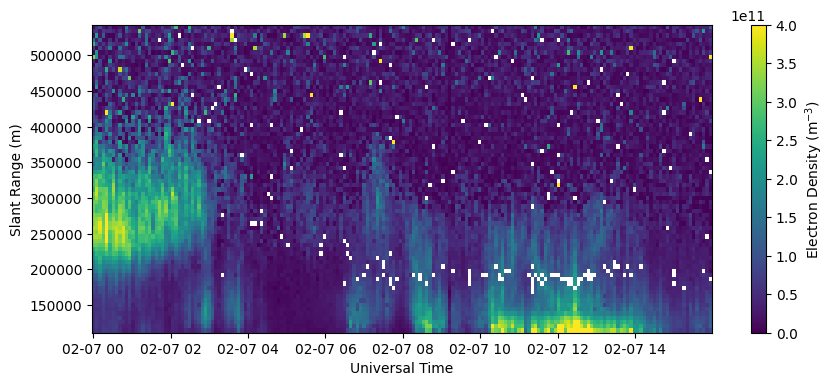

In [4]:
fig = plt.figure(figsize=(10,4))
ax = fig.add_subplot(111)
c = ax.pcolormesh(time, rng[0,np.isfinite(rng[0,:])], Ne[:,0,np.isfinite(rng[0,:])].T, vmin=0., vmax=4.e11)
ax.set_xlabel('Universal Time')
ax.set_ylabel('Slant Range (m)')
fig.colorbar(c, label=r'Electron Density (m$^{-3}$)')

Plot RTI of electron density error in beam 0.

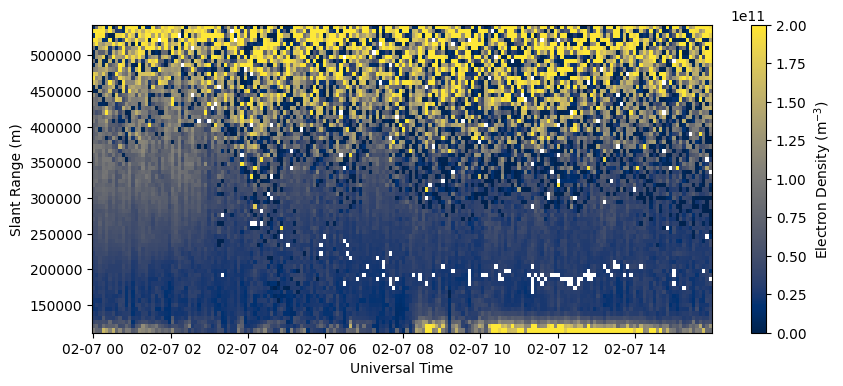

In [5]:
fig = plt.figure(figsize=(10,4))
ax = fig.add_subplot(111)
c = ax.pcolormesh(time, rng[0,np.isfinite(rng[0,:])], dNe[:,0,np.isfinite(rng[0,:])].T, vmin=0., vmax=2.e11, cmap='cividis')
ax.set_xlabel('Universal Time')
ax.set_ylabel('Slant Range (m)')
fig.colorbar(c, label=r'Electron Density (m$^{-3}$)')

Note how the errors increase substantially at longer ranges where the radar is less sensitive.

## Data Quality Filtering
AMISR data files contain two useful data quality parameters, both in the `FittedParams/FitInfo` group.  The first is `fitcode`, which is an indication of whether or not the fitting software used to process the raw data successfully converged. A parameter should only be used if `fitcode` has a value of 1, 2, 3, or 4.  The second is `chi2`, which is the $\chi^2$ goodness-of-fit parameter.  This is expected to be somewhere around 1 because of statistical variability.  If `chi2` is substantially greater than 1, it indicates this was a very poor fit and the model is not a good match for the data, and therefor the output parameter should not be used.  If `chi2` is substantially less than 1, it is also suspect because it suggests very little variance in the data, which is not characteristic of incoherent scatter.  It is possible that this point is instead a coherent echo off a hard-target (such as a metallic satellite in the radar's beam), which erroneously looks like a very high density value with a very low error.  A reasonable value for `chi2` is between 0.1 - 10 for most situations.

In [6]:
with h5py.File(filename, 'r') as h5:
    fitcode = h5['FittedParams/FitInfo/fitcode'][:]
    chi2 = h5['FittedParams/FitInfo/chi2'][:]
    
print(Ne.shape, fitcode.shape, chi2.shape)

(188, 11, 74) (188, 11, 74) (188, 11, 74)


Note that the `fitcode` and `chi2` arrays have the same shape as all the other data arrays.  These data quality parameters can be applied to all data arrays equally - there are not separate data quality parameters for each of the four main data parameter.

Plot electron data filtered based on data quality parameters.

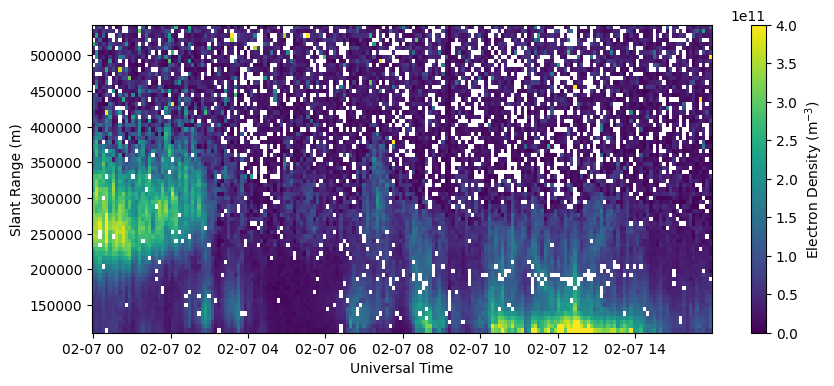

In [7]:
bad_data = np.logical_or(~np.isin(fitcode, [1,2,3,4]), np.logical_or(chi2<0.1, chi2>10.))
Ne_filt = Ne.copy()
Ne_filt[bad_data] = np.nan

fig = plt.figure(figsize=(10,4))
ax = fig.add_subplot(111)
c = ax.pcolormesh(time, rng[0,np.isfinite(rng[0,:])], Ne_filt[:,0,np.isfinite(rng[0,:])].T, vmin=0., vmax=4.e11)
ax.set_xlabel('Universal Time')
ax.set_ylabel('Slant Range (m)')
fig.colorbar(c, label=r'Electron Density (m$^{-3}$)')

Plot electron density filtered by data quality parameters and where the density error is greater than the density (relative error greater than 1).

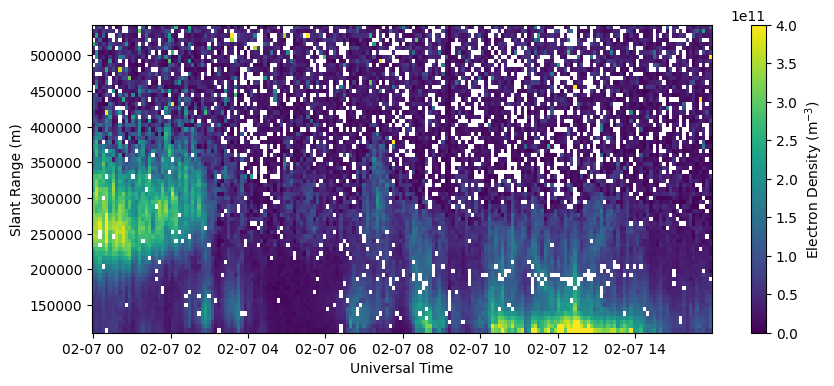

In [8]:
bad_data = np.logical_or(~np.isin(fitcode, [1,2,3,4]), np.logical_or(chi2<0.1, chi2>10.), Ne<dNe)
Ne_filt = Ne.copy()
Ne_filt[bad_data] = np.nan

fig = plt.figure(figsize=(10,4))
ax = fig.add_subplot(111)
c = ax.pcolormesh(time, rng[0,np.isfinite(rng[0,:])], Ne_filt[:,0,np.isfinite(rng[0,:])].T, vmin=0., vmax=4.e11)
ax.set_xlabel('Universal Time')
ax.set_ylabel('Slant Range (m)')
fig.colorbar(c, label=r'Electron Density (m$^{-3}$)')